In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from time import time
%matplotlib inline

In [2]:
df_leans = pd.read_pickle('data/df_leans.pkl')

### Create the identical stratified sample that was used for LDA topic modeling

In [3]:
y = df_leans.leaning.values
corpus = df_leans.content
stratified_sample, _, stratified_out, _ = train_test_split(corpus, y, test_size=.90, stratify=y, random_state=5)

In [4]:
df_sample = df_leans.copy()
df_sample = df_sample[df_sample.index.isin(stratified_sample.index)]

In [7]:
df_sample = df_sample.reset_index().drop('index', axis=1)

In [8]:
df_sample

,id,title,publication,author,date,year,month,url,content,leaning,factual
0,17293,Weak Federal Powers Could Limit Trump’s Climat...,New York Times,Justin Gillis,2017-01-03,2017.0,1.0,NaN,With Donald J. Trump about to take control of ...,Left-Center,High
1,17318,Tips for Your Post-Holiday Clutter Purge - The...,New York Times,Michelle Higgins,2017-04-11,2017.0,4.0,NaN,With the year winding down and New Year’s reso...,Left-Center,High
2,17321,"France Lets Workers Turn Off, Tune Out and Liv...",New York Times,Alissa J. Rubin,2017-01-03,2017.0,1.0,NaN,PARIS — If the world does not envy the Fren...,Left-Center,High
3,17352,"In Republicans’ Ethics Office Gambit, a Specta...",New York Times,Carl Hulse,2017-01-05,2017.0,1.0,NaN,WASHINGTON — Majorities in Congress often o...,Left-Center,High
4,17361,How We Put Together Our 52 Places to Go List -...,New York Times,NaN,2017-01-15,2017.0,1.0,NaN,"For the 12th straight year, the Travel section...",Left-Center,High
...,...,...,...,...,...,...,...,...,...,...,...
14252,218016,"With new monuments in Nevada, Utah, Obama adds...",Washington Post,Juliet Eilperin,2016-12-28,2016.0,12.0,https://web.archive.org/web/20161229004018/htt...,President Obama on Wednesday created new...,Left-Center,High
14253,218017,Memo to Trump: There can be only one president...,Washington Post,Ruth Marcus,2016-12-28,2016.0,12.0,https://web.archive.org/web/20161229004018/htt...,One of the hallmarks of our democratic system...,Left-Center,High
14254,218052,Rare coast-to-coast cold snap to engulf Lower ...,Washington Post,Jason Samenow,2016-12-29,2016.0,12.0,https://web.archive.org/web/20161230000842/htt...,Frigid air will grip an unusually large p...,Left-Center,High
14255,218055,A CIA calendar the CIA gift shop refuses to se...,Washington Post,Ian Shapira,2016-12-29,2016.0,12.0,https://web.archive.org/web/20161230000842/htt...,"Far Side cartoons, Ansel Adams landscapes, ...",Left-Center,High


### Preprocess the text

In [37]:
test = df_sample.content[0]
CUSTOM_FILTERS = [lambda x: x.lower(),
                 strip_multiple_whitespaces,
                 strip_numeric,
                 remove_stopwords,
                 strip_punctuation]

In [44]:
def token_preprocess(string):
    tokens = list(tokenize(string, lower=True, deacc=True))
    tokens = preprocess_string(' '.join(tokens), [lambda x: x.lower(),
                 strip_multiple_whitespaces,
                 strip_numeric,
                 remove_stopwords,
                 strip_punctuation,
                 strip_short])
    return tokens

In [61]:
type(token_preprocess(test))

list

### Load bias lexicon


In [15]:
t0 = time()

cleaned = []
for article in df_sample.content:
    cleaned.append(token_preprocess(article))
    
print(time() - t0)

50.044233083724976


In [22]:
biaswords = []

with open('data/bias-lexicon/bias-lexicon.txt') as fin:
    for line in fin.readlines():
        biaswords.append(line)

In [24]:
biaswords = [line.strip('\n') for line in biaswords]

In [70]:
biaswords

['abortion',
 'abuse',
 'abusive',
 'accept',
 'account',
 'accusation',
 'accuse',
 'acknowledge',
 'act',
 'action',
 'addition',
 'adhere',
 'admit',
 'advance',
 'advocate',
 'affair',
 'affirm',
 'aggression',
 'agree',
 'aim',
 'allegation',
 'allege',
 'allegedly',
 'allow',
 'alternative',
 'amazing',
 'america',
 'american',
 'annex',
 'anti-semitism',
 'anti-terrorist',
 'apologetic',
 'appear',
 'apply',
 'arab',
 'area',
 'argue',
 'army',
 'article',
 'assert',
 'attack',
 'attempt',
 'attribute',
 'author',
 'authority',
 'award',
 'away',
 'baby',
 'bad',
 'bank',
 'barbarian',
 'base',
 'bear',
 'begin',
 'behavior',
 'belief',
 'believe',
 'best',
 'best-selling',
 'bestiality',
 'betrayal',
 'biblical',
 'bishop',
 'blame',
 'bombing',
 'book',
 'branch',
 'break',
 'bring',
 'british',
 'building',
 'bus',
 'business',
 'buy',
 'call',
 'capture',
 'case',
 'catholic',
 'century',
 'certain',
 'challenge',
 'change',
 'characterize',
 'charge',
 'chauvenistic',
 'chi

In [47]:
biasstring = ' '.join(biaswords)

In [ ]:
biasstring

In [69]:
len(token_preprocess(biasstring))

642

### Count number of words per article that are in bias lexicon

In [63]:
df_sample['process_text'] = df_sample.content.apply(lambda x: token_preprocess(x))

In [67]:
df_sample['len_processed'] = df_sample.process_text.apply(lambda x: len(x))

In [74]:
countlist = []

for article in df_sample.process_text:
    counter = 0
    for word in article:
        if word in biaswords:
            counter +=1
    countlist.append(counter)

In [76]:
df_sample['biascount'] = pd.Series(countlist)

In [78]:
df_sample['biaspercent'] = df_sample.biascount/df_sample.len_processed

In [96]:
grouped = df_sample.groupby('leaning').biaspercent.mean()*100
grouped.index=['Least Biased', 'Left', 'Left-Center', 'Right-Center','Right', 
       'Right-Extreme']

In [97]:
grouped

Least Biased     15.458066
Left             17.578673
Left-Center      17.309287
Right-Center     18.910385
Right            14.790078
Right-Extreme    18.846440
Name: biaspercent, dtype: float64

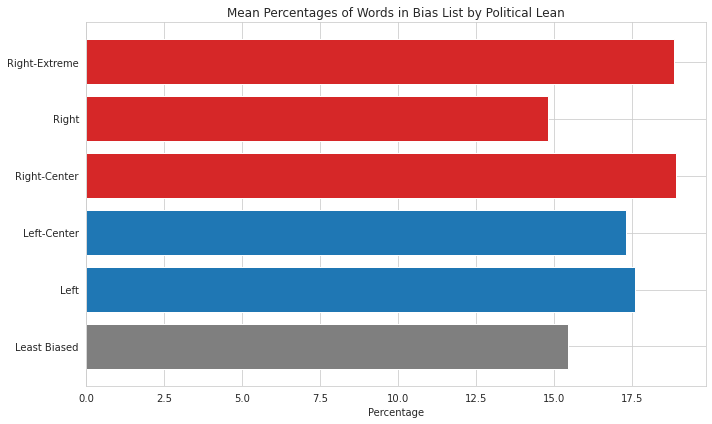

In [108]:
import seaborn as sns
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(10,6))
plt.barh(grouped.index, grouped.values, color = [sns.color_palette()[7],sns.color_palette()[0],sns.color_palette()[0],sns.color_palette()[3],sns.color_palette()[3],sns.color_palette()[3]])
plt.xlabel('Percentage')
plt.title('Mean Percentages of Words in Bias List by Political Lean')

plt.tight_layout()

# plt.savefig('img/biaspolitical.png')
plt.show()

In [104]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]